<a href="https://colab.research.google.com/github/chriscandido/GEE/blob/main/Land_cover_mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import ee
import math
import folium
import subprocess
import numpy as np
import pandas as pd

from pprint import pprint
from folium import plugins
from IPython.display import Image

try:
    import geemap
except ImportError:
    print('Installing geemap ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

try:
    import ipygee
except ImportError:
    print('Installing ipygee ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'ipygee'])

import pprint
import geemap 
import geemap.eefolium as geemap
from ipygee import *

# Configure the pretty printing output & initialize earthengine.
pp = pprint.PrettyPrinter(depth=4)

In [2]:
# Google Earth Engine Authentication
ee.Authenticate()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=3k8HRX4JfWh2O5DdU8H0p9iCyoSmdlyligtNp-EvaQM&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWhIPv8LLBK7zY72H78py2KcKQ7e8iMqHVoeBohf1QXLt45Kd8gY-tY

Successfully saved authorization token.


In [3]:
ee.Initialize()

In [4]:
AOI = ee.Geometry.Polygon([[[120, 15.30],
                            [120, 14],
                            [121.35, 14],
                            [121.35, 15.30]]])
Point_1 = ee.FeatureCollection(
    [ee.Feature(
        ee.Geometry.Point([120.675, 14.65]),
        {
              "system:index": "0"
            })]);
watershed = ee.FeatureCollection('users/cgcandido/ManilaBayWatershed').geometry() 
boundary = ee.FeatureCollection('users/cgcandido/ManilaBayWatershed_boundary').geometry() 

**Basemap**

In [5]:
def add_ee_layer(self, ee_object, vis_params, name): 
    try:    
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):    
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):    
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
    
    except:
        print("Could not display {}".format(name))
    
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [6]:
basemaps = {
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    )}

**Global Variables**

In [7]:
# Global Variables

# Date
startDate = '2019-01-01'
endDate = '2020-12-31' 

# Landsat 8 Bands
opticalBandL8 = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
thermalBandL8 = ['ST_B10']
bandL8 = opticalBandL8 + thermalBandL8

# Landsat 5 Bands
opticalBandL5 = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
thermalBandL5 = ['B6']
bandL5 = opticalBandL5 + thermalBandL5

# Harmonic Model Variables
dependent = 'EVI'
harmonics = 2
harmonicFrequencies = list(range(1, harmonics+1))

def getNames (base, lst_freq) :
    name_lst = []
    for i in lst_freq:
        name_lst.append(ee.String(base + str(i)))
    return name_lst

cosNames = getNames('cos_', harmonicFrequencies);
sinNames = getNames('sin_', harmonicFrequencies);
independents = ee.List(['constant','t']).cat(cosNames).cat(sinNames);

## **Satellite Image Pre-processing**

*   *Satellite Imagery Access*
*   *Cloud and Cloud-shadow Masking*
*   *Harmonic Regression Modelling*

### **Cloud and Cloud-shadow Masking Landsat Satellite Image**

**Landsat 8**

In [8]:
#Function to cloud mask from the pixel_qa band of Landsat 8 data
def mask(image):
    #Bits 3 and 4 are cloud and cloud shaadow respectively
    cloudBitMask = 1 << 3
    cloudShadowBitMask = 1 << 4
    
    #Get QA Pixel Band
    qa = image.select('QA_PIXEL')
    
    #Flag set to zero which indicated clear conditions
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(qa.bitwiseAnd(cloudBitMask).eq(0))
 
    #Return the masked image, scaled reflectance, without QA bands
    opticalBands = image.updateMask(mask).multiply(0.0000275).select(opticalBandL8).copyProperties(image, ["system:time_start"])
    thermalBands = image.updateMask(mask).multiply(0.00341802).add(149.0).select(thermalBandL8).copyProperties(image, ["system:time_start"])
    
    return image.addBands(opticalBands).addBands(thermalBands)


**Landsat 5**

In [9]:
def maskL5(image):
    qa = image.select('pixel_qa');
    #If the cloud bit (5) is set and the cloud confidence (7) is high
    #or the cloud shadow bit is set (3), then it's a bad pixel.
    cloud = qa.bitwiseAnd(1 << 5).And(qa.bitwiseAnd(1 << 7)).Or(qa.bitwiseAnd(1 << 3))
    
    #Remove edge pixels that don't occur in all bands
    mask2 = image.mask().reduce(ee.Reducer.min());
    
    return image.updateMask(cloud.Not()).updateMask(mask2).divide(10000).select(opticalBandL5).copyProperties(image, ["system:time_start"])

### **Harmonic Regression**

In [10]:
def addConstant(image):
    return image.addBands(ee.Image(1));

def addTime(image):
    date = ee.Date(image.get('system:time_start'));
    years = date.difference(ee.Date('1970-01-01'), 'year');
    timeRadians = ee.Image(years.multiply(2*math.pi));
    return image.addBands(timeRadians.rename('t').float());

def addHarmonics(image):
    frequencies = ee.Image.constant(harmonicFrequencies)
    time = ee.Image(image).select('t')
    cosines = time.multiply(frequencies).cos().rename(cosNames)
    sines = time.multiply(frequencies).sin().rename(sinNames)
    return image.addBands(cosines).addBands(sines);

In [11]:
#Landsat 8 Enhanced Vegetation Index (EVI)
collection = ee.ImageCollection('LANDSAT/LC08/C01/T1_8DAY_EVI') #USGS Landsat 8 Level 2, Collection 2, Tier 1
eviLandsat8 = collection.filterDate(startDate, endDate).filterBounds(boundary).select('EVI')

#Harmonic
harmonicLandsat = eviLandsat8.map(addConstant).map(addTime).map(addHarmonics)

In [12]:
#Landsat 5 Enhanced Vegetation Index (EVI)
collection = ee.ImageCollection('LANDSAT/LT05/C01/T1_SR') #USGS Landsat 5 Level 2, Collection 2, Tier 1
eviLandsat5 = collection.filterDate('2010-01-01', '2011-12-31').filterBounds(boundary).map(maskL5).map(addTasseledCap)

#Harmonic
harmonicLandsat5 = eviLandsat5.map(addConstant).map(addTime).map(addHarmonics)

NameError: ignored

In [12]:
# Compute a linear trend.  This will have two bands: 'residuals' and 
# a 2x1 band called coefficients (columns are for dependent variables).
harmonicTrend = harmonicLandsat.select(independents.add(dependent))\
                                .reduce(ee.Reducer.linearRegression(independents.length(),1))

# Flatten the coefficients into a 2-band image|
harmonicTrendCoefficients = harmonicTrend.select('coefficients').arrayProject([0]).arrayFlatten([independents])

#Compute fitted values 
fittedHarmonic = harmonicLandsat.map(lambda image : image\
                                    .addBands(image.select(independents)\
                                    .multiply(harmonicTrendCoefficients)\
                                    .reduce('sum')\
                                    .rename('fitted')));

In [13]:
#Annual Crop
annualCrop = ee.FeatureCollection('users/cgcandido/validation').filter(ee.Filter.eq('lc3', 'annualCrop')) 
MD_ndvi = chart.Image.series(**{'imageCollection': fittedHarmonic,  'region': annualCrop,
'reducer': ee.Reducer.mean(),
'bands' : ['fitted', 'EVI'],
'scale': 500,
'xProperty': 'system:time_start'})
MD_ndvi.renderWidget(width='100%')

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

## **Dataset Preparation**

<b>1. Harmonic Modelling Features</b>
<br>
<blockquote>
    1.1. Mean, Median, Max, Min, and Std Dev Enhanced Vegetation Index (EVI)<br>
    1.2. Phase<br>
    1.3. Amplitude
</blockquote>
<br>
<b>2. Seasonal Composite</b>
<blockquote>
    1.1. Spectral Bands<br>
    1.2. Normalized Difference Water Index (NDWI)<br>
    1.3. Normalized Difference Built-up Index (NDBI)<br>
    1.4. Normalized Difference Vegetation Index (NDVI)<br>
</blockquote>
<br>
<b>2. Othe Features</b>
<blockquote>
    1.1. Nightime Lights<br>
    1.2. Topographic Features (DEM, Slope, Topo Diversity)<br>
</blockquote>


























































































































































































































































### **Harmonic Modelling Features**

In [14]:
#Compute phase, amplitude, and mean EVI
phase = harmonicTrendCoefficients.select('sin_1')\
                                    .atan2(harmonicTrendCoefficients.select('cos_1'))\
                                    .unitScale(-math.pi, math.pi)\
                                    .rename('phase')

amplitude = harmonicTrendCoefficients.select('sin_1')\
                                    .hypot(harmonicTrendCoefficients.select('cos_1'))\
                                    .multiply(5)\
                                    .rename('amplitude')

medEVI = fittedHarmonic.select(['EVI']).median().rename('medianEVI')
aveEVI = fittedHarmonic.select(['EVI']).mean().rename('averageEVI')
maxEVI = fittedHarmonic.select(['EVI']).max().rename('maximumEVI')
minEVI = fittedHarmonic.select(['EVI']).min().rename('minimumEVI')
stdEVI = fittedHarmonic.select(['EVI']).reduce(ee.Reducer.stdDev()).rename('stddevEVI')

harmonicsRgb = ee.Image.cat([phase, amplitude, stdEVI]).hsvToRgb().clip(watershed)
harmonicsRgb2 = ee.Image.cat([phase, amplitude, medEVI]).hsvToRgb().clip(watershed)

### **Seasonal Composite**

In [15]:
def addNDVI(image):
    return image.addBands(image.normalizedDifference(['SR_B5_1', 'SR_B4_1']).rename('NDVI'));

def addNDWI(image):
    return image.addBands(image.normalizedDifference(['SR_B5_1', 'SR_B6_1']).rename('NDWI'));

def addNDBI(image):
    return image.addBands(image.normalizedDifference(['SR_B6_1', 'SR_B5_1']).rename('NDBI'));

def addGrayScale(image):
    
    grayscale = image.expression(
      '(0.3 * R) + (0.59 * G) + (0.11 * B)', {
      'R': image.select(['SR_B4_1']),
      'G': image.select(['SR_B3_1']),
      'B': image.select(['SR_B2_1'])}).rename('grayscale')
    
    return image.addBands(grayscale)

def addEBBI(image):

    ebbi = image.expression(
        '(MIR - NIR) / (10 * sqrt(MIR + TIR))', {
            'NIR': image.select(['SR_B5_1']),
            'MIR': image.select(['SR_B6_1']),
            'TIR': image.select(['ST_B10_1'])
        }
    ).rename('EBBI')

    return image.addBands(ebbi)

def addSAVI(image):

    savi = image.expression(
        '(NIR - R) * (1 - L) / (NIR + R + L)', {
            'NIR': image.select(['SR_B5_1']),
            'R'  : image.select(['SR_B4_1']),
            'L': 0.5
        }
    ).rename('SAVI')

    return image.addBands(savi)

def addNDISI(image):

    ndisi = image.expression(
        '(TIR - ((WI + NIR + MIR) / 3)) / (TIR + ((WI + NIR + MIR) / 3))', {
            'TIR': image.select(['ST_B10_1']),
            'WI' : image.select(['NDWI']),
            'NIR': image.select(['SR_B5_1']),
            'MIR': image.select(['SR_B6_1'])
        }
    ).rename('NDISI')

    return image.addBands(ndisi)
    

In [16]:
#Use Landsat 8 surface reflectance data
drySet01 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2019-01-01', '2019-05-31').map(mask)
drySet02 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2019-11-01', '2020-05-31').map(mask)
dryImage = drySet01.merge(drySet02)

wetSet01 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2019-06-01', '2019-10-31').map(mask)
wetSet02 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2020-06-01', '2020-10-31').map(mask)
wetImage = wetSet01.merge(wetSet02)

dryMean = dryImage.mean().clip(watershed).select(['SR_B1_1','SR_B2_1','SR_B3_1','SR_B4_1','SR_B5_1','SR_B6_1','SR_B7_1','ST_B10'])\
                                    .rename(['DRY_SR_B1','DRY_SR_B2','DRY_SR_B3','DRY_SR_B4','DRY_SR_B5','DRY_SR_B6','DRY_SR_B7','DRY_ST_B10'])
wetMean = wetImage.mean().clip(watershed).select(['SR_B1_1','SR_B2_1','SR_B3_1','SR_B4_1','SR_B5_1','SR_B6_1','SR_B7_1','ST_B10'])\
                                    .rename(['WET_SR_B1','WET_SR_B2','WET_SR_B3','WET_SR_B4','WET_SR_B5','WET_SR_B6','WET_SR_B7','WET_ST_B10'])

In [17]:
# Calculate Band Indices
# Dry and Wet Season NDVI
dryNDVI = dryImage.map(addNDVI).select(['NDVI']).mean().clip(watershed).rename('dryNDVI')
wetNDVI = wetImage.map(addNDVI).select(['NDVI']).mean().clip(watershed).rename('wetNDVI')

# Dry and Wet Season NDWI
dryNDWI = dryImage.map(addNDWI).select(['NDWI']).mean().clip(watershed).rename('dryNDWI')
wetNDWI = wetImage.map(addNDWI).select(['NDWI']).mean().clip(watershed).rename('wetNDWI')

# Dry and Wet Season NDBI
dryNDBI = dryImage.map(addNDBI).select(['NDBI']).mean().clip(watershed).rename('dryNDBI')
wetNDBI = wetImage.map(addNDBI).select(['NDBI']).mean().clip(watershed).rename('wetNDBI')

# Dry and Wet Season SAVI
drySAVI = dryImage.map(addSAVI).select(['SAVI']).mean().clip(watershed).rename('drySAVI')
wetSAVI = wetImage.map(addSAVI).select(['SAVI']).mean().clip(watershed).rename('wetSAVI')

# Dry and Wet Season EBBI
dryEBBI = dryImage.map(addEBBI).select(['EBBI']).mean().clip(watershed).rename('dryEBBI')
wetEBBI = wetImage.map(addEBBI).select(['EBBI']).mean().clip(watershed).rename('wetEBBI')

# Dry and Wet Season NDISI
tempDryNDWI = dryImage.map(addNDWI)
tempWetNDWI = wetImage.map(addNDWI)

dryNDISI = tempDryNDWI.map(addNDISI).select(['NDISI']).mean().clip(watershed).rename('dryNDISI')
wetNDISI = tempWetNDWI.map(addNDISI).select(['NDISI']).mean().clip(watershed).rename('wetNDISI')

In [18]:
# Calculate Texture
kernel = ee.Kernel.square(4, 'pixels')  # filter mean of 5*5

# Compute mean as texture of the landsat 8 collection
dryMedTexture = dryMean.reduceNeighborhood(
    ee.Reducer.median(),
    kernel
)

wetMedTexture = wetMean.reduceNeighborhood(
    ee.Reducer.median(),
    kernel
)

# Compute mean as texture of the landsat 8 collection
dryStdDevTexture = dryMean.reduceNeighborhood(
    ee.Reducer.stdDev(),
    kernel
)

wetStdDevTexture = wetMean.reduceNeighborhood(
    ee.Reducer.stdDev(),
    kernel
)

In [19]:
drystddev_min_max = dryStdDevTexture.reduceRegion(ee.Reducer.minMax(), watershed, 500).getInfo()
pp.pprint(drystddev_min_max)

{'DRY_SR_B1_stdDev_max': 0.04567582723144501,
 'DRY_SR_B1_stdDev_min': 0.0015200388948556052,
 'DRY_SR_B2_stdDev_max': 0.04045542164976896,
 'DRY_SR_B2_stdDev_min': 0.00195565863616749,
 'DRY_SR_B3_stdDev_max': 0.041367718588516705,
 'DRY_SR_B3_stdDev_min': 0.0020944013639945525,
 'DRY_SR_B4_stdDev_max': 0.043028695901626716,
 'DRY_SR_B4_stdDev_min': 0.0021094295039227546,
 'DRY_SR_B5_stdDev_max': 0.1572349939435962,
 'DRY_SR_B5_stdDev_min': 0.0023118393477908803,
 'DRY_SR_B6_stdDev_max': 0.09476751750297618,
 'DRY_SR_B6_stdDev_min': 0.0008008129400115615,
 'DRY_SR_B7_stdDev_max': 0.07587022960301396,
 'DRY_SR_B7_stdDev_min': 0.0006392027631142245,
 'DRY_ST_B10_stdDev_max': 1940.9122135614748,
 'DRY_ST_B10_stdDev_min': 129.5626622107141}


In [20]:
# Max Value Dry
dryndvi_min_max = dryNDVI.reduceRegion(ee.Reducer.minMax(), watershed, 100).getInfo()
dryndwi_min_max = dryNDWI.reduceRegion(ee.Reducer.minMax(), watershed, 100).getInfo()
dryndbi_min_max = dryNDBI.reduceRegion(ee.Reducer.minMax(), watershed, 100).getInfo()
drysavi_min_max = drySAVI.reduceRegion(ee.Reducer.minMax(), watershed, 100).getInfo()
dryebbi_min_max = dryEBBI.reduceRegion(ee.Reducer.minMax(), watershed, 100).getInfo()
dryndisi_min_max = dryNDISI.reduceRegion(ee.Reducer.minMax(), watershed, 100).getInfo()

# Wet Value Dry
wetndvi_min_max = wetNDVI.reduceRegion(ee.Reducer.minMax(), watershed, 100).getInfo()
wetndwi_min_max = wetNDWI.reduceRegion(ee.Reducer.minMax(), watershed, 100).getInfo()
wetndbi_min_max = wetNDBI.reduceRegion(ee.Reducer.minMax(), watershed, 100).getInfo()
wetsavi_min_max = wetSAVI.reduceRegion(ee.Reducer.minMax(), watershed, 100).getInfo()
wetebbi_min_max = wetEBBI.reduceRegion(ee.Reducer.minMax(), watershed, 100).getInfo()
wetndisi_min_max = wetNDISI.reduceRegion(ee.Reducer.minMax(), watershed, 100).getInfo()

### **Ancillary Data**

In [21]:
#Elevation model
alos = ee.Image('JAXA/ALOS/AW3D30/V2_2')
alosTopoDiversity = ee.Image('CSP/ERGo/1_0/Global/ALOS_topoDiversity');

elev = alos.select('AVE_DSM').clip(watershed).rename('Elevation');
slope = ee.Terrain.slope(alos.select('AVE_DSM').clip(watershed)).rename('Slope');
topoDiversity = alosTopoDiversity.select('constant').clip(watershed).rename('Topo_Diversity');

#Nighttime Lights 
viirs = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG')
nighttimeLights = viirs.filterDate(startDate, endDate).median().clip(watershed).select('avg_rad')

### **Dataset Visualization**

In [38]:
#Visualization parameters
vis_params = {'bands': ['DRY_SR_B4', 'DRY_SR_B3', 'DRY_SR_B2'], 'min': 0.1, 'max': 0.6, 'gamma':[0.90, 0.95, 1.0]}

cov_params = {'bands': ['DRY_SR_B6_variance', 'DRY_SR_B5_variance', 'DRY_SR_B4_variance'], 'min': 0.0, 'max': 6,}

ndvi_params = {'min': dryndvi_min_max['dryNDVI_min'], 'max': dryndvi_min_max['dryNDVI_max'], 'palette': ['#8bc4f9', '#c9995c', '#c7d270', '#8add60', '#097210']}

ndbi_params = {'min': dryndbi_min_max['dryNDBI_min'], 'max': dryndbi_min_max['dryNDBI_max'], 'palette': ['0000ff', '00ffff', 'ffff00', 'ff0000', 'ffffff']}

ndisi_params = {'min': dryndisi_min_max['dryNDISI_min'], 'max': dryndisi_min_max['dryNDISI_max'], 'palette': ['0000ff', '00ffff', 'ffff00', 'ff0000', 'ffffff']}

ndwi_params = {'min': dryndwi_min_max['dryNDWI_min'], 'max': dryndwi_min_max['dryNDWI_max'], 'palette': ['0000FF', '00FFFF']}

savi_params = {'min': drysavi_min_max['drySAVI_min'], 'max': drysavi_min_max['drySAVI_max'], 'palette': ['#8bc4f9', '#c9995c', '#c7d270', '#8add60', '#097210']}

elev_params = {'min': 0, 'max': 1000, 'palette': ['0000ff', '00ffff', 'ffff00', 'ff0000', 'ffffff'] }

slope_params = {'min': 0, 'max': 90, 'palette': ['0000ff', '00ffff', 'ffff00', 'ff0000', 'ffffff'] }

topodiv_params = { 'min': 0.0, 'max': 1.0, 'palette': ['0000ff', '00ffff', 'ffff00', 'ff0000', 'ffffff']}

In [42]:
thumbnail2 = dryStdDevTexture.getThumbURL({
  'min': 0,
  'max': 0.002,
  'bands': ['DRY_SR_B4_variance', 'DRY_SR_B3_variance', 'DRY_SR_B2_variance'],
  'dimensions': 500,
  'region': watershed,
});
print('Rectangle region and palette:', thumbnail2);

Rectangle region and palette: https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/7586f755e5cb1cb5fd0bf59c40dd1ab7-e075d11cd45e75fd2f95b594ffcf6bed:getPixels


In [35]:
map = geemap.Map()

map.centerObject(Point_1, 8)
map.addLayer(dryMean, vis_params, 'Landsat 8 Satellite Image')
map.addLayer(dryStdDevTexture, cov_params, 'Texture Image')
map.addLayer(harmonicsRgb2, {'bands':['red','green','blue'], 'max': 0.7}, 'Phenological Features')
map.addLayer(dryNDVI, ndvi_params, 'Dry Season NDVI')
map.addLayer(dryNDWI, ndwi_params, 'Dry Season NDWI')
map.addLayer(dryNDBI, ndbi_params, 'Dry Season NDBI')
map.addLayer(drySAVI, savi_params, 'Dry Season SAVI')
map.addLayer(dryNDISI, ndisi_params, 'Dry Season NDISI')
map.addLayer(nighttimeLights, {}, 'Night Time Lights')
map.addLayer(elev, elev_params, 'Elevation')
map.addLayer(topoDiversity, topodiv_params, 'Topographic Diversity')
map

## **Classification**

In [22]:
#Image Composite
composite = ee.Image.cat([dryMean,wetMean,\
                          dryNDVI,wetNDVI,dryNDWI,wetNDWI,dryNDBI,wetNDBI,drySAVI,wetSAVI,dryEBBI,wetEBBI,\
                          medEVI,aveEVI,maxEVI,minEVI,stdEVI,phase,amplitude,\
                          dryMedTexture,wetMedTexture,dryStdDevTexture,wetStdDevTexture,\
                          elev,slope,topoDiversity,nighttimeLights])

#Band names
bands = ['DRY_SR_B1','DRY_SR_B2','DRY_SR_B3','DRY_SR_B4','DRY_SR_B5','DRY_SR_B6','DRY_SR_B7','DRY_ST_B10',\
        'WET_SR_B1','WET_SR_B2','WET_SR_B3','WET_SR_B4','WET_SR_B5','WET_SR_B6','WET_SR_B7','WET_ST_B10',\
        'dryNDVI','wetNDVI','dryNDWI', 'wetNDWI','dryNDBI','wetNDBI','drySAVI','wetSAVI','dryEBBI','wetEBBI',\
        'medianEVI','averageEVI','maximumEVI','minimumEVI','stddevEVI','phase','amplitude',\
        'DRY_SR_B1_median','DRY_SR_B2_median','DRY_SR_B3_median','DRY_SR_B4_median','DRY_SR_B5_median','DRY_SR_B6_median','DRY_SR_B7_median',\
        'WET_SR_B1_median','WET_SR_B2_median','WET_SR_B3_median','WET_SR_B4_median','WET_SR_B5_median','WET_SR_B6_median','WET_SR_B7_median',\
        'DRY_SR_B1_stdDev','DRY_SR_B2_stdDev','DRY_SR_B3_stdDev','DRY_SR_B4_stdDev','DRY_SR_B5_stdDev','DRY_SR_B6_stdDev','DRY_SR_B7_stdDev',\
        'WET_SR_B1_stdDev','WET_SR_B2_stdDev','WET_SR_B3_stdDev','WET_SR_B4_stdDev','WET_SR_B5_stdDev','WET_SR_B6_stdDev','WET_SR_B7_stdDev',\
        'Elevation','Slope','Topo_Diversity','avg_rad']

In [23]:
pp.pprint(composite.getInfo())

{'bands': [{'crs': 'EPSG:4326',
            'crs_transform': [1, 0, 0, 0, 1, 0],
            'data_type': {'max': 1.8022125,
                          'min': 0,
                          'precision': 'double',
                          'type': 'PixelType'},
            'dimensions': [2, 4],
            'id': 'DRY_SR_B1',
            'origin': [120, 13]},
           {'crs': 'EPSG:4326',
            'crs_transform': [1, 0, 0, 0, 1, 0],
            'data_type': {'max': 1.8022125,
                          'min': 0,
                          'precision': 'double',
                          'type': 'PixelType'},
            'dimensions': [2, 4],
            'id': 'DRY_SR_B2',
            'origin': [120, 13]},
           {'crs': 'EPSG:4326',
            'crs_transform': [1, 0, 0, 0, 1, 0],
            'data_type': {'max': 1.8022125,
                          'min': 0,
                          'precision': 'double',
                          'type': 'PixelType'},
            'dimensions': [2

In [24]:
def ee_to_pandas(ee_object):
    """Converts an ee.FeatureCollection to pandas dataframe.

    Args:
        ee_object (ee.FeatureCollection): ee.FeatureCollection.

    Raises:
        TypeError: ee_object must be an ee.FeatureCollection

    Returns:
        pd.DataFrame: pandas DataFrame
    """
    import pandas as pd

    if not isinstance(ee_object, ee.FeatureCollection):
        raise TypeError("ee_object must be an ee.FeatureCollection")

    try:
        data = ee_object.map(lambda f: ee.Feature(None, f.toDictionary()))
        data = [x["properties"] for x in data.getInfo()["features"]]
        df = pd.DataFrame(data)
        return df
    except Exception as e:
        raise Exception(e)

### **Training Dataset Preparation**

In [25]:
features = ee.FeatureCollection('users/cgcandido/validation')

trainingData = ee_to_pandas(features)
trainingData #Land cover types

,id,lc2,lc3
0,1,water,aquaculture
1,11,water,water
2,6,wetland,mangrove
3,2,bareLand,barrenLand
4,4,naturalVeg,forest
5,5,naturalVeg,grassLand
6,9,naturalVeg,shrubLand
7,0,cultivatedLand,annualCrop
8,8,cultivatedLand,permanentCrop
9,7,cultivatedLand,paddyRice


In [28]:
training = composite.select(bands).sampleRegions(**{\
        'collection':features,\
        'properties':['id'],\
        'scale':90,\
        'geometries': True,\
        'tileScale':16 })

#Export Training dataset
task = ee.batch.Export.table.toDrive(**{'collection':training,\
  'folder':'Colab Notebooks',\
  'description':'Training',\
  'fileFormat':'CSV'\
});

task.start()

### **Feature and Model Selection**

In [3]:
# Sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.metrics import precision_score, roc_auc_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve, accuracy_score

# Miscellaneous
import warnings
import subprocess
import seaborn as sns
import lightgbm as lgbm
import matplotlib.pyplot as plt
warnings.simplefilter(action='ignore', category=FutureWarning)

# PyCaret
try:
    import pycaret
except ImportError:
    print('Installing pycaret ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'pycaret[full]'])

import pycaret
from pycaret.classification import *
from pycaret.utils import check_metric

# BorutaShap
! pip install BorutaShap
from BorutaShap import BorutaShap, load_data
from xgboost import XGBClassifier

# Shap
!pip install shap
import shap

# eli5
!pip install eli5
import eli5

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [4]:
# Load Data
path = '/content/drive/MyDrive/Colab Notebooks/Training.csv'
data = pd.read_csv(path)

In [5]:
data.describe()

,DRY_SR_B1,DRY_SR_B1_median,DRY_SR_B1_stdDev,DRY_SR_B2,DRY_SR_B2_median,DRY_SR_B2_stdDev,DRY_SR_B3,DRY_SR_B3_median,DRY_SR_B3_stdDev,DRY_SR_B4,DRY_SR_B4_median,DRY_SR_B4_stdDev,DRY_SR_B5,DRY_SR_B5_median,DRY_SR_B5_stdDev,DRY_SR_B6,DRY_SR_B6_median,DRY_SR_B6_stdDev,DRY_SR_B7,DRY_SR_B7_median,DRY_SR_B7_stdDev,DRY_ST_B10,Elevation,Slope,Topo_Diversity,WET_SR_B1,WET_SR_B1_median,WET_SR_B1_stdDev,WET_SR_B2,WET_SR_B2_median,WET_SR_B2_stdDev,WET_SR_B3,WET_SR_B3_median,WET_SR_B3_stdDev,WET_SR_B4,WET_SR_B4_median,WET_SR_B4_stdDev,WET_SR_B5,WET_SR_B5_median,WET_SR_B5_stdDev,WET_SR_B6,WET_SR_B6_median,WET_SR_B6_stdDev,WET_SR_B7,WET_SR_B7_median,WET_SR_B7_stdDev,WET_ST_B10,amplitude,averageEVI,avg_rad,dryEBBI,dryNDBI,dryNDVI,dryNDWI,drySAVI,id,maximumEVI,medianEVI,minimumEVI,phase,stddevEVI,wetEBBI,wetNDBI,wetNDVI,wetNDWI,wetSAVI
count,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000,77670.000000
mean,0.222578,0.221669,0.007104,0.230675,0.229494,0.007779,0.261657,0.260324,0.009422,0.251418,0.249481,0.010829,0.435788,0.436589,0.035080,0.331718,0.331076,0.021252,0.273439,0.271573,0.014738,40818.888919,300.138561,9.541757,0.345050,0.223138,0.221283,0.010082,0.231748,0.229447,0.010610,0.265768,0.263293,0.012179,0.250578,0.247237,0.013477,0.462185,0.463627,0.037175,0.331608,0.330373,0.020303,0.269293,0.266448,0.014936,30899.424181,0.343957,0.356810,2.285106,-0.000600,-0.119120,0.236999,0.119120,0.071980,5.452015,0.714230,0.332916,0.057194,0.344160,0.175182,-0.000754,-0.144990,0.263454,0.144990,0.080999
std,0.027088,0.023165,0.006857,0.027138,0.022237,0.007676,0.028855,0.022617,0.008647,0.036716,0.029799,0.010529,0.128303,0.124052,0.021590,0.076026,0.071267,0.012670,0.054261,0.047455,0.011996,1699.555894,383.795768,11.622441,0.369023,0.028642,0.022006,0.010818,0.028862,0.021402,0.011355,0.030504,0.022203,0.011597,0.036456,0.027355,0.013211,0.142559,0.139504,0.019601,0.071338,0.066153,0.012145,0.047680,0.039508,0.012545,2617.477677,0.224350,0.238176,7.376224,0.000527,0.102808,0.170540,0.102808,0.051427,3.262644,0.303037,0.252969,0.157864,0.269936,0.061248,0.000559,0.098892,0.176562,0.098892,0.054637
min,0.107855,0.142485,0.000487,0.125152,0.160929,0.000521,0.196983,0.219567,0.000541,0.188760,0.208600,0.000434,0.178008,0.186342,0.000703,0.202308,0.204525,0.000458,0.203406,0.204744,0.000365,36286.875000,-45.000000,0.000000,0.000000,0.103703,0.159119,0.000879,0.145503,0.176709,0.000935,0.203857,0.224678,0.001516,0.195364,0.205908,0.001370,0.193009,0.206590,0.001199,0.204468,0.208780,0.000888,0.204373,0.208138,0.000676,22295.218750,0.002306,-0.144371,0.075000,-0.002020,-0.332870,-0.106204,-0.179620,-0.024813,0.000000,0.075998,-0.180817,-1.000000,0.000054,0.024187,-0.002256,-0.342503,-0.113328,-0.164402,-0.031101
25%,0.210999,0.211618,0.003662,0.215287,0.215414,0.003895,0.241881,0.242101,0.005448,0.225616,0.225095,0.005180,0.361544,0.368471,0.019752,0.278134,0.291818,0.014344,0.234474,0.238619,0.008003,39707.885417,8.000000,0.666872,0.025672,0.210966,0.212004,0.004458,0.216712,0.217240,0.004665,0.246675,0.247017,0.005994,0.228277,0.228735,0.005913,0.370458,0.382349,0.024204,0.292959,0.308028,0.013315,0.239493,0.242962,0.007574,29211.779412,0.177818,0.161172,0.235000,-0.

##### ***Data Preparation***

In [6]:
# Optical Data + Topographic Data
features_01 = ['DRY_SR_B1','DRY_SR_B2','DRY_SR_B3','DRY_SR_B4','DRY_SR_B5','DRY_SR_B6','DRY_SR_B7','DRY_ST_B10',\
        'WET_SR_B1','WET_SR_B2','WET_SR_B3','WET_SR_B4','WET_SR_B5','WET_SR_B6','WET_SR_B7','WET_ST_B10',\
        'dryNDVI','wetNDVI','dryNDWI', 'wetNDWI','dryNDBI','wetNDBI','drySAVI','wetSAVI','dryEBBI','wetEBBI',\
        'medianEVI','averageEVI','maximumEVI','minimumEVI','stddevEVI','phase','amplitude',\
        'DRY_SR_B1_median','DRY_SR_B2_median','DRY_SR_B3_median','DRY_SR_B4_median','DRY_SR_B5_median','DRY_SR_B6_median','DRY_SR_B7_median',\
        'WET_SR_B1_median','WET_SR_B2_median','WET_SR_B3_median','WET_SR_B4_median','WET_SR_B5_median','WET_SR_B6_median','WET_SR_B7_median',\
        'DRY_SR_B1_stdDev','DRY_SR_B2_stdDev','DRY_SR_B3_stdDev','DRY_SR_B4_stdDev','DRY_SR_B5_stdDev','DRY_SR_B6_stdDev','DRY_SR_B7_stdDev',\
        'WET_SR_B1_stdDev','WET_SR_B2_stdDev','WET_SR_B3_stdDev','WET_SR_B4_stdDev','WET_SR_B5_stdDev','WET_SR_B6_stdDev','WET_SR_B7_stdDev',\
        'Elevation','Slope','Topo_Diversity','avg_rad']

# Optical Data 
features_02 = ['DRY_SR_B1','DRY_SR_B2','DRY_SR_B3','DRY_SR_B4','DRY_SR_B5','DRY_SR_B6','DRY_SR_B7',\
        'WET_SR_B1','WET_SR_B2','WET_SR_B3','WET_SR_B4','WET_SR_B5','WET_SR_B6','WET_SR_B7',\
        'dryNDVI','wetNDVI','dryNDWI', 'wetNDWI','dryNDBI','wetNDBI','drySAVI','wetSAVI','dryEBBI','wetEBBI',\
        'medianEVI','averageEVI','maximumEVI','minimumEVI','stddevEVI','phase','amplitude']

# Split training dataset to train and test
train, test = train_test_split(data, test_size=0.3)

x_train, y_train = train[features_01], train['id'] # Optical + Topo
x_test, y_test = test[features_01], test['id'] 

x_train2, y_train2 = train[features_02], train['id'] # Optical
x_test2, y_test2 = test[features_02], test['id']

# Normalize Data
x_trained_scaled = x_train.copy()
  
for column in x_trained_scaled.columns:
    x_trained_scaled[column] = (x_trained_scaled[column] - x_trained_scaled[column].min()) / (x_trained_scaled[column].max() - x_trained_scaled[column].min())

# Convert array to dataframe
yTrain = pd.DataFrame(y_train)
yTest  = pd.DataFrame(y_test)

yTrain2 = pd.DataFrame(y_train2)
yTest2  = pd.DataFrame(y_test2)


df = pd.concat([x_trained_scaled, yTrain], axis=1)
df2 = pd.concat([x_train2, yTrain2], axis=1)


In [7]:
x_trained_scaled

,DRY_SR_B1,DRY_SR_B2,DRY_SR_B3,DRY_SR_B4,DRY_SR_B5,DRY_SR_B6,DRY_SR_B7,DRY_ST_B10,WET_SR_B1,WET_SR_B2,WET_SR_B3,WET_SR_B4,WET_SR_B5,WET_SR_B6,WET_SR_B7,WET_ST_B10,dryNDVI,wetNDVI,dryNDWI,wetNDWI,dryNDBI,wetNDBI,drySAVI,wetSAVI,dryEBBI,wetEBBI,medianEVI,averageEVI,maximumEVI,minimumEVI,stddevEVI,phase,amplitude,DRY_SR_B1_median,DRY_SR_B2_median,DRY_SR_B3_median,DRY_SR_B4_median,DRY_SR_B5_median,DRY_SR_B6_median,DRY_SR_B7_median,WET_SR_B1_median,WET_SR_B2_median,WET_SR_B3_median,WET_SR_B4_median,WET_SR_B5_median,WET_SR_B6_median,WET_SR_B7_median,DRY_SR_B1_stdDev,DRY_SR_B2_stdDev,DRY_SR_B3_stdDev,DRY_SR_B4_stdDev,DRY_SR_B5_stdDev,DRY_SR_B6_stdDev,DRY_SR_B7_stdDev,WET_SR_B1_stdDev,WET_SR_B2_stdDev,WET_SR_B3_stdDev,WET_SR_B4_stdDev,WET_SR_B5_stdDev,WET_SR_B6_stdDev,WET_SR_B7_stdDev,Elevation,Slope,Topo_Diversity,avg_rad
3970,0.210711,0.163422,0.065582,0.059331,0.105272,0.031590,0.018376,0.361917,0.162126,0.115957,0.049986,0.051649,0.073176,0.029357,0.015932,0.265382,0.215806,0.221898,0.440593,0.420561,0.559407,0.579439,0.163305,0.179567,0.630167,0.634239,0.139907,0.185077,0.141337,0.589500,0.199389,0.188402,0.136621,0.376143,0.314137,0.103143,0.120319,0.118820,0.068154,0.045714,0.224389,0.180057,0.058406,0.112829,0.074613,0.042300,0.018908,0.021748,0.029023,0.047627,0.049984,0.133936,0.090516,0.055495,0.014104,0.019215,0.028319,0.028433,0.124085,0.074346,0.037821,0.023764,0.016811,0.022055,0.002654
45134,0.244565,0.214265,0.161124,0.162735,0.513359,0.358954,0.231976,0.514467,0.192507,0.144481,0.113775,0.072859,0.734490,0.344943,0.161640,0.287805,0.584271,0.868108,0.483180,0.839325,0.516820,0.160675,0.535896,0.829518,0.544345,0.206189,0.567826,0.702224,1.000000,0.823315,0.648351,0.138119,0.371542,0.507391,0.491858,0.443273,0.470991,0.645393,0.616319,0.525494,0.337484,0.332348,0.374483,0.407747,0.705397,0.700861,0.478132,0.145829,0.185042,0.241219,0.317966,0.172403,0.173642,0.249241,0.135792,0.157984,0.197513,0.261156,0.257651,0.248604,0.274045,0.055133,0.027179,0.068787,0.108222
29572,0.232098,0.170716,0.079047,0.050800,0.599066,0.210490,0.092777,0.073980,0.535627,0.475716,0.400717,0.373488,0.744171,0.302020,0.135479,0.517844,0.829225,0.644706,0.821613,0.878991,0.178387,0.121009,0.768764,0.584372,0.254380,0.135035,0.565060,0.730366,0.970364,0.798515,0.700897,0.378143,0.244299,0.404136,0.324402,0.135929,0.082942,0.735945,0.348569,0.180834,0.681493,0.666919,0.602744,0.592829,0.752757,0.459756,0.227242,0.045016,0.042932,0.069965,0.063723,0.359110,0.153895,0.087906,0.789659,0.747402,0.677908,0.660545,0.478906,0.214537,0.100853,0.235741,0.339545,0.862949,0.001787
36834,0.207558,0.154914,0.065828,0.042632,0.519643,0.165116,0.070353,0.322906,0.154408,0.114058,0.062447,0.052263,0.431776,0.193680,0.098428,0.772001,0.784134,0.694076,0.821027,0.743378,0.178973,0.256622,0.707764,0.607898,0.293005,0.389554,0.591590,0.700456,0.851824,0.796320,0.441801,0.846740,0.120591,0.361503,0.284181,0.101537,0.064742,0.643659,0.277854,0.147615,0.223493,0.182514,0.096185,0.100730,0.600161,0.373931,0.179921,0.027048,0.029600,0.068809,0.047121,0.407980,0.177087,0.083263,0.026773,0.025739,0.034817,0.028105,0.258516,0.105263,0.058477,0.480989,0.482243,0.938993,0.002112
40087,0.203414,0.153545,0.063492,0.047500,0.536012,0.190457,0.086134,0.323905,0.179475,0.134873,0.092785,0.073252,0.554123,0.264891,0.132799,0.697733,0.788503,0.756812,0.791106,0.775749,0.208894,0.224251,0.716278,0.690043,0.303649,0.321704,0.480679,0.616274,0.840097,0.777872,0.573489,0.320310,0.394068,0.350226,0.281967,0.095380,0.076306,0.683310,0.313581,0.163090,0.247022,0.205321,0.127163,0.123719,0.709336,0.447728,0.209838,0.017625,0.013961,0.031116,0.016042,0.255174,0.110498,0.044687,0.022477,0.020476,0.031178,0.020844,0.192663,0.103986,0.052279,0.705798,0.297296,0.834812,0.001842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

##### ***Setting up Environment***

In [8]:
# Initialize setup
"""
Parameters

Feature Selection : a subset of features are selected using a combination of various permutation importance techniques including 
Random Forest, Adaboost and Linear correlation with target variable. The size of the subset is dependent on the feature_selection_threshold parameter

Feature Selection Threshold : Threshold value used for feature selection.

Feature Selection Method : Algorithm for feature selection. ‘classic’ method uses permutation feature importance techniques. 
Other possible value is ‘boruta’ which uses boruta algorithm for feature selection

Fold Strategy : Choice of cross validation strategy. Possible values are: ‘kfold’, ‘stratifiedkfold’, ‘groupkfold’ , ‘timeseries’, 
a custom CV generator object compatible with scikit-learn.

log_experiment : When set to True, all metrics and parameters are logged on the MLFlow server.

"""
exp = setup(data = df, target = "id", feature_selection = True, feature_selection_method='boruta', feature_selection_threshold = 0.70,\
             fold=5, fold_strategy="stratifiedkfold", preprocess = False, use_gpu=True)

,Description,Value
0,session_id,7580
1,Target,id
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(54369, 66)"
5,Missing Values,False
6,Numeric Features,65
7,Categorical Features,0
8,Transformed Train Set,"(38058, 65)"
9,Transformed Test Set,"(16311, 65)"


##### ***Compare Models***

In [9]:
# Compare machine learning algorithms 
best = compare_models(sort = "F1", n_select = 3)
print (best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9959,1.0000,0.9834,0.9959,0.9959,0.9950,0.9950,180.298
xgboost,Extreme Gradient Boosting,0.9955,1.0000,0.9774,0.9955,0.9955,0.9945,0.9945,3.732
et,Extra Trees Classifier,0.9933,0.9999,0.9693,0.9933,0.9932,0.9919,0.9919,2.818
rf,Random Forest Classifier,0.9916,0.9999,0.9670,0.9916,0.9915,0.9898,0.9898,8.918
knn,K Neighbors Classifier,0.9915,0.9992,0.9648,0.9915,0.9914,0.9897,0.9897,4.088
gbc,Gradient Boosting Classifier,0.9888,0.9995,0.9310,0.9887,0.9887,0.9864,0.9864,805.346
dt,Decision Tree Classifier,0.9768,0.9873,0.9355,0.9769,0.9768,0.9720,0.9720,2.678
qda,Quadratic Discriminant Analysis,0.9729,0.9982,0.8894,0.9731,0.9726,0.9674,0.9675,0.308
lr,Logistic Regression,0.9621,0.9986,0.8625,0.9615,0.9615,0.9542,0.9542,26.136
lda,Linear Discriminant Analysis,0.9427,0.9972,0.9143,0.9480,0.9442,0.9310,0.9313,0.410


[<catboost.core.CatBoostClassifier object at 0x7fc984b52ad0>, XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=7580, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='gpu_hist', use_label_encoder=True,
              validate_parameters=1, verbosity=0), ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_

##### ***Create and Tune Model***

In [10]:
"""
Model Tuning

The tune_model() function is a random grid search of hyperparameters over a pre-defined search space and scores it using 
stratified cross validation. The output prints a score grid that shows Accuracy, AUC, Recall, Precision, F1 and Kappa by fold. 
By default, it is set to optimize Accuracy but this can be changed using optimize parameter
"""

model = create_model('xgboost')
tuned_model = tune_model(model, optimize='F1')
print (tuned_model)
#blend = blend_models(estimator_list=[tuned_catboost,tuned_rf,tuned_knn])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9958,1.0,0.9743,0.9958,0.9958,0.9949,0.9949
1,0.9961,1.0,0.9850,0.9961,0.9961,0.9952,0.9952
2,0.9970,1.0,0.9696,0.9970,0.9969,0.9964,0.9964
3,0.9967,1.0,0.9693,0.9967,0.9967,0.9960,0.9960
4,0.9949,1.0,0.9753,0.9949,0.9949,0.9938,0.9938
Mean,0.9961,1.0,0.9747,0.9961,0.9961,0.9953,0.9953
SD,0.0007,0.0,0.0057,0.0007,0.0007,0.0009,0.0009


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=7580, reg_alpha=0.1,
              reg_lambda=1e-06, scale_pos_weight=13.700000000000003,
              subsample=0.7, tree_method='gpu_hist', use_label_encoder=True,
              validate_parameters=1, verbosity=0)


##### ***Analyze and Interpret Model***

In [11]:
# Evaluate Tuned Model
"""
AUC (Area under the ROC Curve ) : measures the entire two-dimensional area underneath the entire ROC curve. AUC provides an aggregate measure of performance 
across all possible classification thresholds. One way of interpreting AUC is as the probability that the model ranks a random positive example more highly 
than a random negative example.

Precision-Recall Curve : a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of 
result relevancy, while recall is a measure of how many truly relevant results are returned. A high area under the curve represents both high recall and high precision, 
where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning 
accurate results (high precision), as well as returning a majority of all positive results (high recall).

"""
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

##### ***Feature Selection***

In [23]:
from sklearn.inspection import permutation_importance

def permutation(clf, X, y):
   result = permutation_importance(clf, X, y, n_repeats=100, random_state=0)
   chosen_feats = []
   for i in result.importances_mean.argsort()[::-1]:
      if result.importances_mean[i] - 2 * result.importances_std[i] >0:
          chosen_feats.append(X.columns[i])
   return chosen_feats, result

In [49]:
# Summary Plot 
shap.initjs()
id = 0
explainer = shap.TreeExplainer(tuned_model)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
  expected_value = expected_value[1][id]
print (expected_value[id])

features = test[test['id'] == id]
features_display = x_test.loc[features.index]
features_display_mean = pd.DataFrame(features_display.mean()).T

with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  shap_values = explainer.shap_values(features_display)
  shap_interaction_values = explainer.shap_interaction_values(features_display)
if isinstance(shap_interaction_values, list):
  shap_interaction_values = shap_interaction_values[id]
  
shap.summary_plot(shap_values[id], features_display, plot_type="violin")
#shap.decision_plot(expected_value[id], shap_values[id], features_display_mean, ignore_warnings= True)

nan


AssertionError: ignored

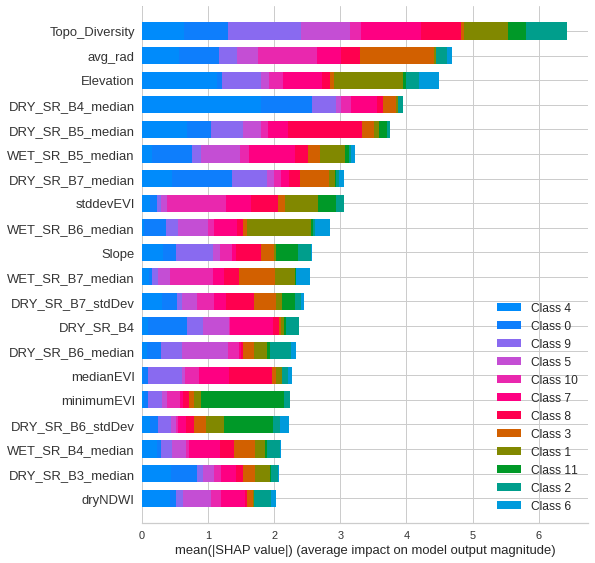

In [40]:
# Force Plot
interpret_model(tuned_model, plot = "summary")

##### ***Finalize and Predict Model***

In [41]:
# Predict Unseen data
predictions = predict_model(tuned_model, data=x_test)

In [42]:
holdout_score = pull()
type(holdout_score)
display(holdout_score)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9951,1.0000,0.9679,0.9952,0.9951,0.9941,0.9941
1,0.9938,1.0000,0.9685,0.9938,0.9938,0.9925,0.9925
2,0.9938,0.9999,0.9843,0.9938,0.9938,0.9925,0.9925
3,0.9942,1.0000,0.9530,0.9942,0.9941,0.9930,0.9930
4,0.9950,1.0000,0.9800,0.9950,0.9950,0.9940,0.9940
Mean,0.9944,1.0000,0.9707,0.9944,0.9944,0.9932,0.9932
SD,0.0006,0.0000,0.0109,0.0006,0.0006,0.0007,0.0007


In [43]:
# Print Accuracy, F1, and Kappa Coefficient
print('Classification Accuracy {:.2f}%'.format(100 * check_metric(yTest, predictions.Label, 'Accuracy')))
print('Classification F1-score {:.2f}%'.format(100 * check_metric(yTest, predictions.Label, 'F1')))
print('Classification Kappa {:.3f}'.format(check_metric(yTest, predictions.Label, 'Kappa')))

Classification Accuracy 99.53%
Classification F1-score 99.53%
Classification Kappa 0.994


In [40]:
selected_features = ['avg_rad', 'Topo_Diversity', 'Elevation', 'phase', 'minimumEVI', 'amplitude', 'stddevEVI', 'Slope', 'medianEVI', 'averageEVI']

var = ['']

task = ee.batch.Export.image.toDrive(**{'image':composite.select(selected_features).toFloat(),\
                                        'description':'composite',\
                                        'scale':30,\
                                        'region':watershed,\
                                        'folder':'Colab Notebooks'});

task.start()

i = 1
for features in selected_features:
  print("No. of Variable: ", i)
  print("Variable Name: ", features)
  print("-------------------------------------------------------------------------------------------------------------------")
  i += 1

print ('Done ...')

No. of Variable:  1
Variable Name:  avg_rad
-------------------------------------------------------------------------------------------------------------------
No. of Variable:  2
Variable Name:  Topo_Diversity
-------------------------------------------------------------------------------------------------------------------
No. of Variable:  3
Variable Name:  Elevation
-------------------------------------------------------------------------------------------------------------------
No. of Variable:  4
Variable Name:  phase
-------------------------------------------------------------------------------------------------------------------
No. of Variable:  5
Variable Name:  minimumEVI
-------------------------------------------------------------------------------------------------------------------
No. of Variable:  6
Variable Name:  amplitude
-------------------------------------------------------------------------------------------------------------------
No. of Variable:  7
Variable

In [120]:
task = ee.batch.Export.image.toDrive(**{'image':dryContrast.toFloat(),\
                                        'description':'contrast',\
                                        'scale':30,\
                                        'region':watershed,\
                                        'folder':'Colab Notebooks'});
task.start()

## **Model Prediction**

In [41]:
from osgeo.gdalconst import *
from osgeo import gdal
from gdalconst import *

import os 
import enum
import matplotlib as mpl

try:
    import rasterio
except ImportError:
    print('Installing rasterio ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'rasterio'])

try:
    import geopandas
except ImportError:
    print('Installing rasterio ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geopandas'])

import rasterio
import geopandas as gpd 

Installing rasterio ...
Installing rasterio ...


In [43]:
#Load Composite
raster_path = '/content/drive/MyDrive/Colab Notebooks/composite.tif'

raster = gdal.Open(raster_path, gdal.GA_ReadOnly)

gtr = raster.GetGeoTransform()
dvr = raster.GetDriver()
col = raster.RasterXSize
row = raster.RasterYSize
bnd = raster.RasterCount
prj = raster.GetProjection()
    
array = []
    
for b in range(bnd+1)[1::]:
  band = raster.GetRasterBand(b)
  arry = band.ReadAsArray().astype(np.float32)
  array.append(arry)
  del band, arry

array = np.dstack(b for b in array)

# Array shape
w, h, b = array.shape

array = array.reshape(w*h,b)
array.shape

tcmalloc: large alloc 1545191424 bytes == 0x557f8f4e4000 @  0x7f34e504d1e7 0x7f34db80446e 0x7f34db854c7b 0x7f34db854d18 0x7f34db8fc010 0x7f34db8fc73c 0x7f34db8fc85d 0x557eb126f749 0x7f34db841ef7 0x557eb126d437 0x557eb126d240 0x557eb12e0973 0x557eb12db9ee 0x557eb126ebda 0x557eb12e0d00 0x557eb11add14 0x7f34db841fb3 0x557eb126d437 0x557eb126d240 0x557eb12e0973 0x557eb12db9ee 0x557eb126ebda 0x557eb12e0d00 0x557eb12db9ee 0x557eb12db6f3 0x557eb12d9b60 0x557eb126d349 0x557eb126d240 0x557eb12e0973 0x557eb1360dd5 0x557eb12ddc6f


(38629584, 10)

In [44]:
# Split training dataset to train and test
selected_features = ['avg_rad', 'Topo_Diversity', 'Elevation', 'phase', 'minimumEVI', 'amplitude', 'stddevEVI', 'Slope', 'medianEVI', 'averageEVI']
train, test = train_test_split(data, test_size=0.3)

x_train, y_train = train[selected_features], train['id'] # Optical + Topo
x_test, y_test = test[selected_features], test['id']

# Convert array to dataframe
yTrain = pd.DataFrame(y_train)
yTest  = pd.DataFrame(y_test)

dfTrain = pd.concat([x_train, yTrain], axis=1)
dfTrain

,avg_rad,Topo_Diversity,Elevation,phase,minimumEVI,amplitude,stddevEVI,Slope,medianEVI,averageEVI,id
50636,0.400,0.199085,83,0.541735,0.194877,0.056470,0.184248,1.045034,0.369657,0.428017,7
14856,0.315,0.084964,0,0.078297,-0.243223,0.301901,0.132516,0.000000,-0.141540,-0.085090,11
62671,2.640,0.038336,13,0.322374,0.121557,0.062149,0.068913,1.438872,0.323070,0.314848,10
19453,0.225,0.901640,920,0.543693,0.155091,0.178639,0.210808,20.754921,0.435515,0.509159,4
4195,0.375,0.029021,5,0.182232,-0.052834,0.088449,0.038862,0.463735,0.036661,0.040262,1
...,...,...,...,...,...,...,...,...,...,...,...
30960,0.200,0.761276,660,0.421554,0.171027,0.210733,0.222156,24.691313,0.519455,0.539463,4
24467,0.240,0.638704,556,0.679473,0.228845,0.579165,0.195144,16.557959,0.675137,0.623657,4
32284,1.115,0.723277,783,0.297344,0.204100,0.565855,0.171325,22.574154,0.434688,0.459768,4
54859,1.445,0.137480,7,0.435719,0.052260,0.351055,0.196327,1.854334,0.378125,0.444069,7


In [45]:
# Setup Environment
exp = setup(data = dfTrain, target = "id", feature_selection = True,\
             fold=5, fold_strategy="stratifiedkfold", preprocess = False, use_gpu=True)

,Description,Value
0,session_id,8563
1,Target,id
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(44286, 11)"
5,Missing Values,False
6,Numeric Features,10
7,Categorical Features,0
8,Transformed Train Set,"(31000, 10)"
9,Transformed Test Set,"(13286, 10)"


In [47]:
# Create and Tune Model
model = create_model('lightgbm')
tuned_model = tune_model(model, optimize='F1')
print (tuned_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9798,0.9996,0.9049,0.9796,0.9796,0.9756,0.9756
1,0.9794,0.9997,0.9373,0.9793,0.9792,0.9750,0.9751
2,0.9787,0.9997,0.9315,0.9786,0.9784,0.9742,0.9743
3,0.9813,0.9997,0.9227,0.9812,0.9811,0.9774,0.9774
4,0.9755,0.9995,0.9137,0.9756,0.9754,0.9704,0.9704
Mean,0.9789,0.9996,0.9220,0.9789,0.9788,0.9745,0.9745
SD,0.0019,0.0001,0.0117,0.0018,0.0019,0.0023,0.0023


LGBMClassifier(bagging_fraction=0.6, bagging_freq=4, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.15, max_depth=-1,
               min_child_samples=56, min_child_weight=0.001, min_split_gain=0,
               n_estimators=130, n_jobs=-1, num_leaves=80, objective=None,
               random_state=8563, reg_alpha=0.001, reg_lambda=0.2, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [48]:
labels_unique = np.unique(y_train)
labels_unique

# Setup Model
model = lgbm.LGBMClassifier(random_state=42, objective='multiclass', 
                            num_class=len(labels_unique),
                            metric='multi_logloss')

clf_sw = lgbm.LGBMClassifier(**model.get_params())

# Optimal parameter
clf_sw.set_params(**tuned_model.get_params())

# Fit classifier
clf_sw.fit(x_train, y_train)

LGBMClassifier(bagging_fraction=0.6, bagging_freq=4, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.15, max_depth=-1,
               metric='multi_logloss', min_child_samples=56,
               min_child_weight=0.001, min_split_gain=0, n_estimators=130,
               n_jobs=-1, num_class=12, num_leaves=80, objective=None,
               random_state=8563, reg_alpha=0.001, reg_lambda=0.2, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [49]:
# Mask Invalid Pixels
feature = np.ma.masked_invalid(array)
mask = np.ma.getmask(feature)
feature_mask = np.ma.array(feature, mask=mask)
feature_mask.shape

# Predict Model
predict = clf_sw.predict(feature_mask)
predict

tcmalloc: large alloc 1545191424 bytes == 0x557feb74e000 @  0x7f34e504d1e7 0x7f34db80446e 0x7f34db854c7b 0x7f34db854d97 0x7f34db84e4a5 0x7f34db8f99d0 0x557eb126d544 0x557eb126d240 0x557eb12e1627 0x557eb12db9ee 0x557eb126ebda 0x557eb12e0d00 0x557eb12db9ee 0x557eb12db6f3 0x557eb12d9b60 0x557eb126d349 0x557eb126d240 0x557eb12e0973 0x557eb1360dd5 0x557eb12ddc6f 0x557eb1360dd5 0x557eb12ddc6f 0x557eb1360dd5 0x557eb126d2ed 0x557eb135ee1d 0x557eb12e0e99 0x557eb126eafa 0x557eb12dc915 0x557eb126eafa 0x557eb12dcc0d 0x557eb12db9ee
tcmalloc: large alloc 3708444672 bytes == 0x5580761ba000 @  0x7f34e504f001 0x7f34db80454f 0x7f34db854b58 0x7f34db858b17 0x7f34db8f7203 0x557eb126d544 0x557eb126d240 0x557eb12e1627 0x557eb12dbced 0x557eb126ebda 0x557eb12dc915 0x557eb12dbced 0x557eb126ebda 0x557eb12dcc0d 0x557eb12db9ee 0x557eb126ebda 0x557eb12dcc0d 0x557eb12db9ee 0x557eb126f48c 0x557eb126f698 0x557eb12ddfe4 0x557eb12db9ee 0x557eb126f271 0x557eb126f698 0x557eb12ddfe4 0x557eb12dbced 0x557eb126f271 0x557eb126

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 

array([1, 1, 1, ..., 7, 7, 7])

In [50]:
dfPred = np.array(pd.DataFrame(predict))
tiff = dfPred.reshape(w,h)
tiff.shape

(8068, 4788)

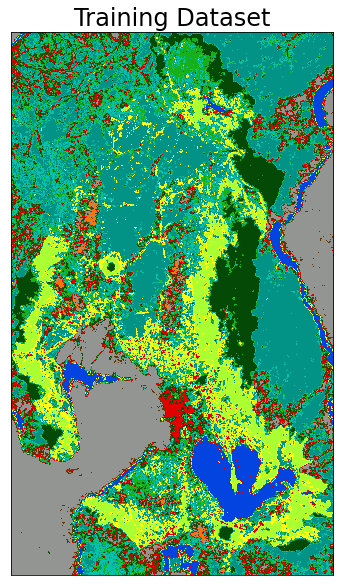

In [25]:
class LULC(enum.Enum):
    ANNUAL_CROP     = (0,  'Annual Crop',   'xkcd:orange')
    AQUACULTURE     = (1,  'Aquaculture',   'xkcd:grey')
    BARREN_LAND     = (2,  'Barren land',   'xkcd:brown')
    DENSE_URBAN     = (3,  'Dense Urban',   'xkcd:red')
    FOREST          = (4,  'Forest',        'xkcd:darkgreen')
    GRASSLAND       = (5,  'Grassland',     'xkcd:green')
    MANGROVE        = (6,  'Mangrove',      'xkcd:turquoise')
    PADDY_RICE      = (7,  'Paddy Rice',    'xkcd:Teal')
    PERMANENT_CROP  = (8,  'Permanent Crop','xkcd:yellow')
    SHRUBLAND       = (9,  'Shrubland',     'xkcd:lime')
    SPARSE_URBAN    = (10, 'Sparse Urban',  'xkcd:red')
    WATER           = (11, 'Water',         'xkcd:blue')
    
    def __init__(self, val1, val2, val3):
        self.id = val1
        self.class_name = val2
        self.color = val3

lulc_cmap = mpl.colors.ListedColormap([entry.color for entry in LULC])

plt.figure(figsize=(20,10))
plt.imshow(tiff, cmap=lulc_cmap)
plt.xticks([])
plt.yticks([])
plt.title('Training Dataset', fontsize=24)
plt.show()

In [51]:
# Export Data 
driver = raster.GetDriver()
outputPath = '/content/drive/MyDrive/Colab Notebooks'

with rasterio.open(raster_path) as src:
  b1 = src.read(1)

kwargs = src.meta
kwargs.update(dtype=rasterio.float32, count=1)
with rasterio.open (outputPath+'/'+'prediction_Landcover2018'+'.tiff', 'w', **kwargs) as dst:
  dst.write_band(1, tiff.astype(rasterio.float32))